In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
ufo = pd.read_csv("scrubbed.csv")

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# cleaning

In [3]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape',
       'duration (seconds)', 'duration (hours/min)', 'comments',
       'date posted', 'latitude', 'longitude '], dtype=object)

### cleaning up the 'datetime' feature
- it has both '24:00' and '00:00' values but only 00:00 are relevant
- so we find them and replace with "00:00"
- then we convert `str` type to `TimeStamp`

In [4]:
row = -1
counter = 0
for i in ufo['datetime']:
    row += 1
    date, time_stamp = i.split()
    if time_stamp == '24:00':
        counter += 1
        ufo.iloc[row, 0] = " ".join([date, "00:00"])

In [5]:
ufo['datetime'] = pd.to_datetime(ufo['datetime'])

### cleaning duration (seconds)

when trying to convert 'duration (seconds)' feature to `float`, we encounter `ValueError`

In [34]:
ufo['duration (seconds)'].astype(float)


ValueError: could not convert string to float: '0.5`'

**trying to find what causes the error : **

In [6]:
typos = []

row = -1 
for el in ufo['duration (seconds)']:
    row += 1
    if type(el) == float:
        continue
    for char in el:
        if char.isnumeric() or char == ".":
            continue
        else:
            typos.append((row, el))
            break
typos

[(27822, '2`'), (35692, '8`'), (41201, '2631600  '), (58591, '0.5`')]

**there're just a few typos, we'll just correct them manually : **


In [7]:
correct = {27822: '2', 35692: '8', 41201: '2631600', 58591: '0.5'  }

In [8]:
for k, v in correct.items():
    ufo.loc[k, 'duration (seconds)'] = v

**converting duration to ```float``` type : **

In [9]:
ufo['duration_sec'] = ufo['duration (seconds)'].astype(float)

## checking up empty values : 

In [10]:
ufo.isnull().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
duration_sec               0
dtype: int64

**replacing Nans with 'unknown' and 'no description' : **

In [11]:
ufo['state'].fillna('unknown', inplace=True)
ufo['country'].fillna('unknown', inplace=True)
ufo['shape'].fillna('unknown', inplace=True)
ufo['comments'].fillna('no description', inplace=True)

** removing duration as we have that feature in seconds we can convert in any value : **

In [12]:
ufo.drop(['duration (hours/min)', 'duration (seconds)' ], axis=1, inplace=True)

** adding duration in minutes for more convenience : **

In [13]:
ufo['duration_min'] = ufo['duration_sec'] / 60

## clearing latitude and longitude : 

In [43]:
ufo['latitude'].astype(float)

ValueError: could not convert string to float: '33q.200088'

In [44]:
row = -1
container = []
for i in ufo['latitude']:
    row += 1
    try:
        float(i)
    except ValueError:
        container.append((i, row))

In [45]:
container

[('33q.200088', 43782)]

** finding index of the column : **

In [46]:
for c, v in enumerate(ufo.columns.values):
    print(c, '--->', v)

0 ---> datetime
1 ---> city
2 ---> state
3 ---> country
4 ---> shape
5 ---> comments
6 ---> date posted
7 ---> latitude
8 ---> longitude 
9 ---> duration_sec
10 ---> duration_min


In [47]:
ufo.iloc[43782 , 7] = '33.200088'

In [48]:
ufo['latitude'] = ufo['latitude'].astype(float)

** 'longitude' feature name has empty space at the end, which may cause embarassement and hate to programming. Let's fix it : **

In [50]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec',
       'duration_min'], dtype=object)

In [51]:
ufo.columns.values[8] = 'longitude'

In [52]:
ufo['longitude'] = ufo['longitude '].astype(float)

# Exploratory analysis and visualization : 

## UFO witnesses over time


the data are taken from : https://www.history.com/news/ufo-sightings-credible-modern they say, it's credible. 

In [89]:
ufo['year'] = ufo['datetime'].dt.year.astype(int)
temp = ufo['year'].value_counts().sort_index()

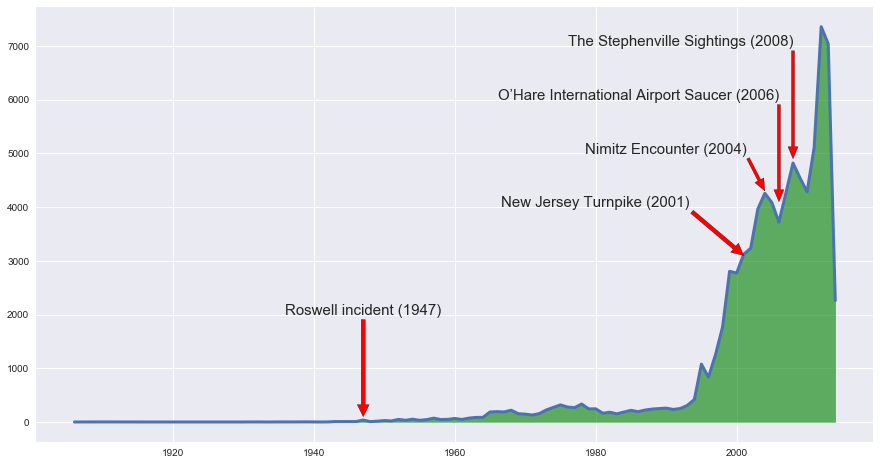

In [90]:
fig = plt.figure(figsize=(15, 8))
plt.plot(temp, lw=3)
plt.fill_between(temp.index, temp, color='green', alpha=0.6)

plt.annotate("Roswell incident (1947)", xy=(1947, 100), xytext=(1947, 2000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.annotate("New Jersey Turnpike (2001)", xy=(2001, 3100), xytext=(1980, 4000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.annotate("Nimitz Encounter (2004)", xy=(2004, 4300), xytext=(1990, 5000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))

plt.annotate("O’Hare International Airport Saucer (2006)", xy=(2006, 4100), xytext=(2006, 6000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))
plt.annotate("The Stephenville Sightings (2008)", xy=(2008, 4900), xytext=(2008, 7000), size=15,
             horizontalalignment='right',
             arrowprops=dict(facecolor="red", width=3, headwidth=10))


#plt.axvline(2001, lw=1, color="black") 
#plt.axvline(2004, lw=1, alpha=0.25, color="black") 

#plt.axvline(2006, lw=1, alpha=0.25, color="black") 

#plt.axvline(2008, lw=1, alpha=0.25, color="black") 

plt.show()

In [91]:
ufo.columns.values

array(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec',
       'duration_min', 'longitude', 'year'], dtype=object)

## UFO shapes

In [94]:
temp = ufo['shape'].value_counts().sort_values(ascending=False)

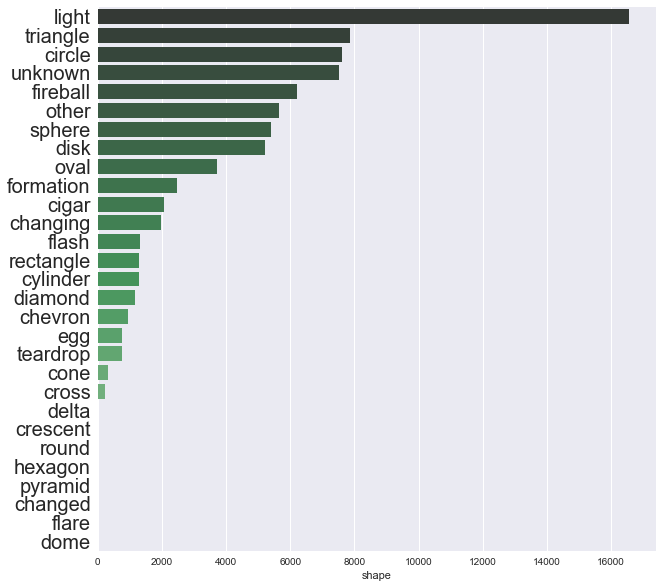

In [96]:
plt.figure(figsize=(10,10))
sns.barplot(temp, temp.index, palette="Greens_d")
plt.yticks(fontsize=20)
plt.show()

## shapes over years. Rise of Unknowns and Light Prevalence

In [97]:
shape_year = ufo[['shape', 'year']]

You can clearly observe the pike in the unknown shape. we call it: "The Rise of Unknowns". Further studies are needed to investigate this phenomena. As we've created this category ourselves, we lack data on this year, or, perhaps ufo's were so careful, so that people couldn't grasp their shape
The second investigation is the prevalence of the light. Which is an issue as well

In [98]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [99]:
data = []

for ufo_shape in temp.index[:]:
    df = pd.DataFrame(shape_year.loc[ufo['shape'] == ufo_shape, 'year'])
    shape = df['year'].value_counts()
    shape.sort_index(ascending=True, inplace=True)
    trace = go.Scatter(x=shape.index, y=shape, mode="lines", name=ufo_shape)
    data.append(trace)
    
iplot(data)



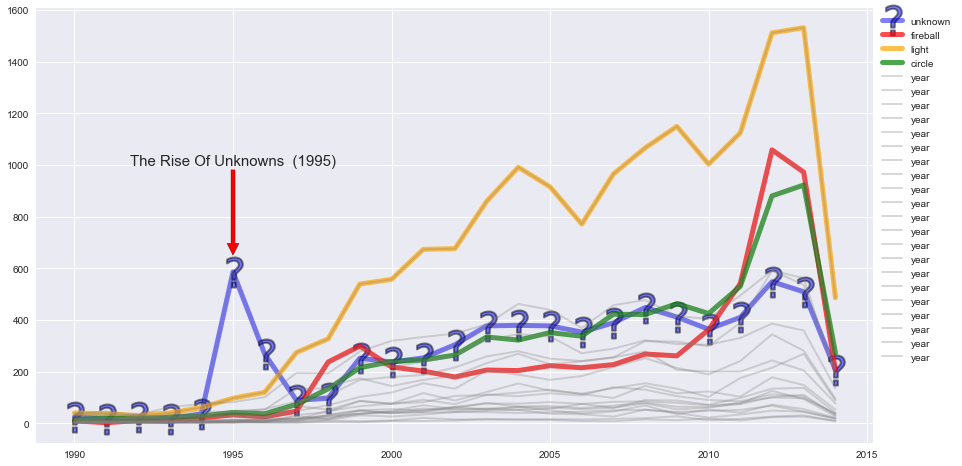

In [108]:
plt.figure(figsize=(15, 8))

unk = pd.DataFrame(shape_year.loc[ufo['shape'] == 'unknown', 'year'])
unk = unk['year'].value_counts()
unk.sort_index(ascending=True, inplace=True)   
plt.plot(unk.loc[1990:], label='unknown', lw=5, alpha=0.5, c='blue', marker='$?$', ms="30", markeredgewidth=2, 
        markeredgecolor='black')

fire = pd.DataFrame(shape_year.loc[ufo['shape'] == 'fireball', 'year'])
fire = fire['year'].value_counts()
fire.sort_index(ascending=True, inplace=True)   
plt.plot(fire.loc[1990:], label='fireball', lw=5, alpha=0.7, c='red')

light = pd.DataFrame(shape_year.loc[ufo['shape'] == 'light', 'year'])
light = light['year'].value_counts()
light.sort_index(ascending=True, inplace=True)   
plt.plot(light.loc[1990:], label='light', lw=5, alpha=0.7, c='orange')

circle = pd.DataFrame(shape_year.loc[ufo['shape'] == 'circle', 'year'])
circle = circle['year'].value_counts()
circle.sort_index(ascending=True, inplace=True)   
plt.plot(circle.loc[1990:], label='circle', lw=5, alpha=0.7, c='green')

for ufo_shape in temp.index[:21]:
    df = pd.DataFrame(shape_year.loc[ufo['shape'] == ufo_shape, 'year'])
    shape = df['year'].value_counts()
    shape.sort_index(ascending=True, inplace=True)
    plt.plot(shape.loc[1990:], lw=2, c='grey', alpha=0.3)

plt.annotate("The Rise Of Unknowns  (1995)", xy=(1995, 650), xytext=(1995, 1000), size=15,
             horizontalalignment='center',
             arrowprops=dict(facecolor="red"))

plt.legend(bbox_to_anchor=(1.0, 1.0))



## UFO per country

In [110]:
temp = ufo['country'].value_counts()
temp.sort_values(inplace=True, ascending=False)

In [111]:
x_label = temp.index.values
y_data = temp.tolist()

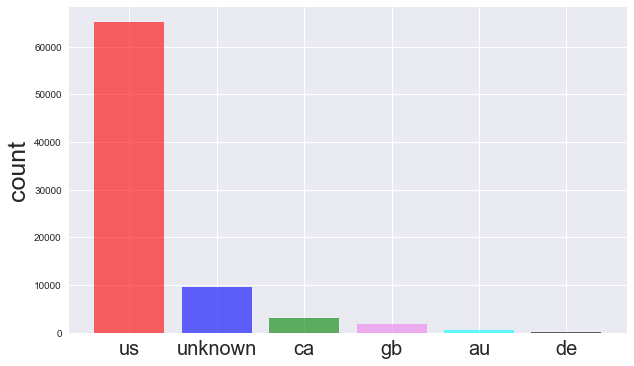

In [112]:
fig = plt.figure(figsize=(10, 6))
plt.bar(range(len(x_label)),  y_data, color=['red', 'blue', 'green', 'violet', 'cyan', 'black'], alpha=0.6)
plt.xticks(list(range(len(x_label))), x_label, fontsize=20)
plt.ylabel('count', fontsize=25)

plt.show()

## UFO visit cities mostly in the USA

In [113]:
temp = ufo['city'].value_counts()
temp.sort_values(inplace=True, ascending=False)

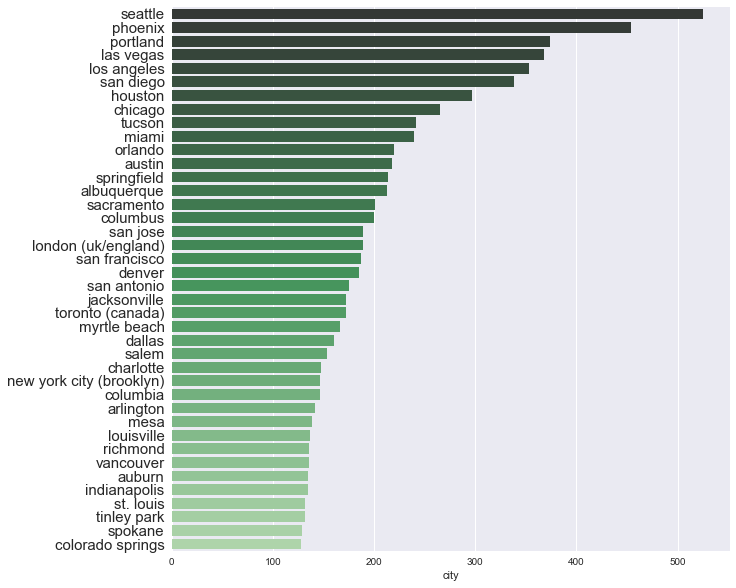

In [117]:
plt.figure(figsize=(10,10))
sns.barplot(temp[:40], temp.index[:40], palette="Greens_d")
plt.yticks(fontsize=15)
plt.show()

## UFO prefers California most of all

In [120]:
f = open('us_states_codes.txt')

In [121]:
d = {}
for line in f:
    d[line.split()[2].lower()] = line.split()[0]

ufo['state'] = ufo['state'].map(d)

In [122]:
temp = ufo['state'].value_counts()
temp.sort_values(inplace=True, ascending=False)
x_label = temp.index.values
y_data = temp.tolist()

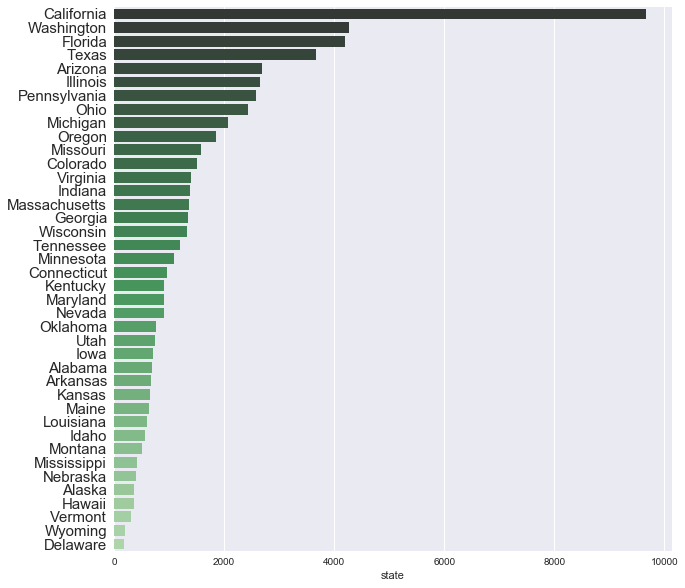

In [123]:
plt.figure(figsize=(10,10))
sns.barplot(temp, temp.index, palette="Greens_d")
plt.yticks(fontsize=15)
plt.show()

# TODO: create here chloroplete saturaion map by iplot plotly

- intersting stuff to do:
1. are there correlation with population and num of witnesses of UFO?

## Duration 

- this feature is rather skewed : we have many witnesses which observed ufo for about more than 24 hours
- dropping these outliers, we get rather nice distribution
- most people say round values of observing UFOs. Look at that 5, 10, 15, 20, 25, 30 etc values

**conclusion draft : **
- UFOs give a chance to be observed for about 1 minute.

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


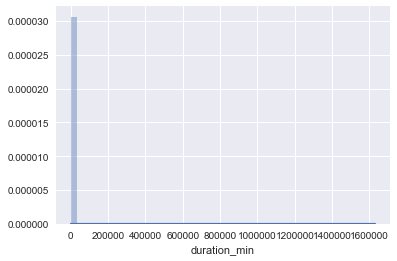

In [66]:
sns.distplot(ufo['duration_min'])
plt.show()

In [53]:
ufo['duration_min'].mean()

150.28148360574346

In [54]:
ufo['duration_min'].std()

10336.946504858231

In [55]:
ufo['duration_min'].min()

1.6666666666666667e-05

In [75]:
ufo['duration_min'].max() / 60

27176.666666666668

In [57]:
temp = ufo['duration_min']

In [58]:
temp = temp.sort_values()

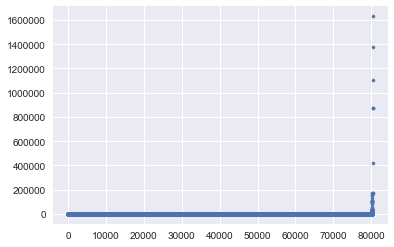

In [60]:
plt.scatter(range(1, len(temp) + 1), temp.values, s=10)
plt.show()

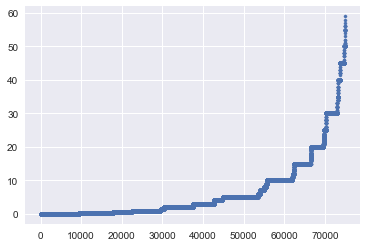

In [68]:
plt.scatter(range(1, len(temp) + 1), temp.values, s=10)
plt.show()

In [61]:
q = ufo["duration_min"].quantile(0.95)

In [62]:
temp = temp[temp < q]

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


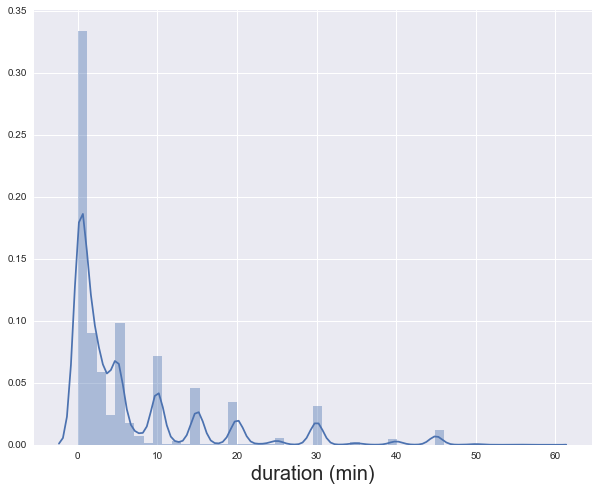

In [74]:
plt.figure(figsize=(10, 8))
sns.distplot(temp)
plt.xlabel('duration (min)', fontsize=20)
plt.show()

In [76]:
ufo.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec', 'duration_min',
       'longitude'],
      dtype='object')

# Comments analysis

In [124]:
text = ' '.join(ufo['comments'])

In [125]:
import re

In [126]:
text = re.sub('[!@#&44]', '', text)
text = text.replace('Note', '')
text = text.replace('quot', '')

In [127]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image

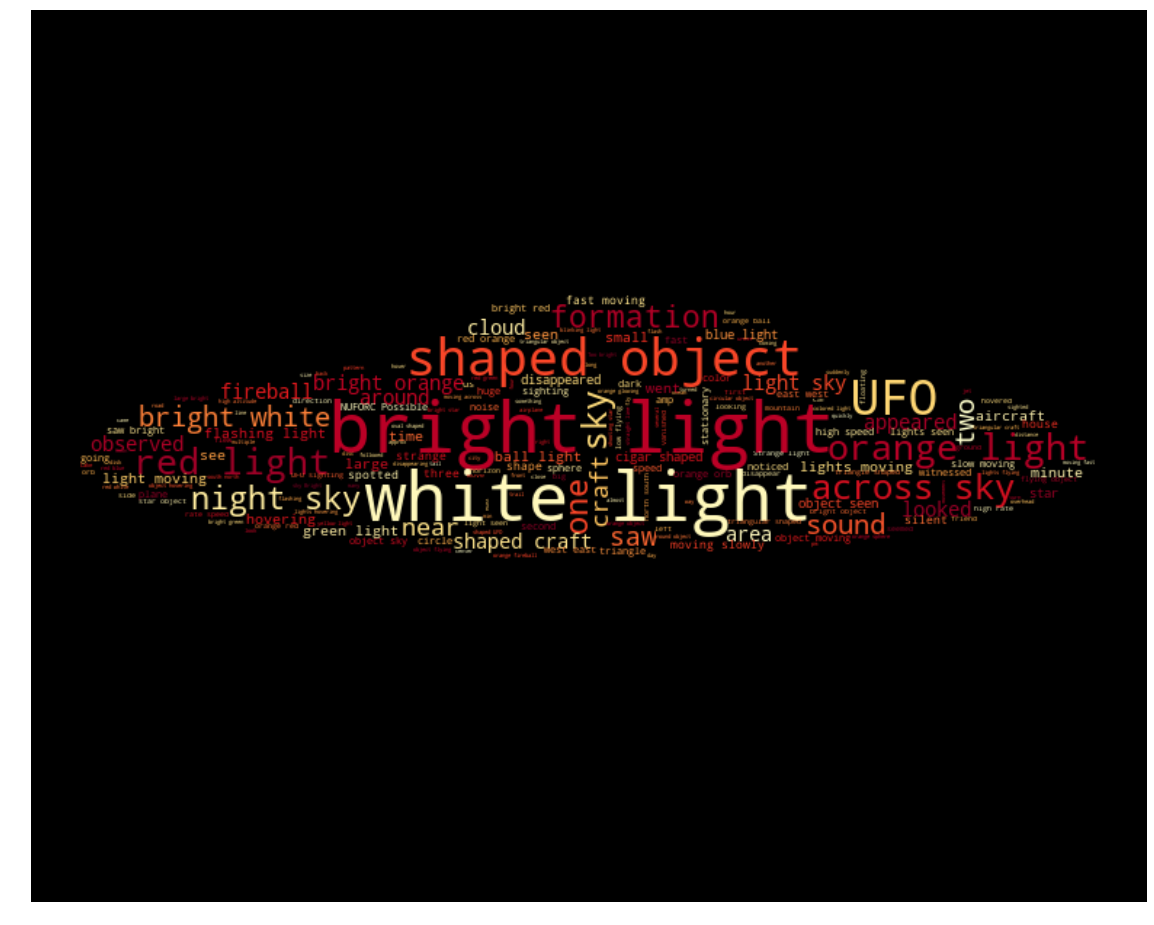

In [128]:
# Create the wordcloud object
wave_mask = np.array(Image.open( "ufo_craft.jpg"))

#wordcloud = WordCloud(width=480, height=480, margin=0, mask=wave_mask, background_color='skyblue', 
#colormap='Greens').generate(text)
wordcloud = WordCloud(width=480, height=480, margin=0, mask=wave_mask, colormap="YlOrRd").generate(text)

plt.figure(figsize=(20,20))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Time analysis

**conclustion draft : ** 
- UFO loves warm and summer as people do
- but unlike people and similar to vampires, it likes to stay in the shadow


In [129]:
ufo['month'] = ufo['datetime'].dt.month.astype(int)
ufo['day'] = ufo['datetime'].dt.day.astype(int)
ufo['day of the week'] = ufo['datetime'].dt.dayofweek.astype(int)
ufo['hour'] = ufo['datetime'].dt.hour.astype(int)
ufo['day of year'] = ufo['datetime'].dt.strftime('%m-%d')

In [131]:
temp = ufo['day of the week'].value_counts()
temp.sort_index(inplace=True)

<BarContainer object of 7 artists>

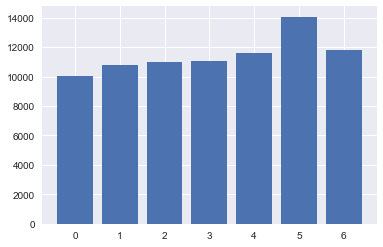

In [132]:
plt.bar(temp.index, temp)

In [133]:
temp = ufo['month'].value_counts()
temp.sort_index(inplace=True, ascending=False)

<BarContainer object of 12 artists>

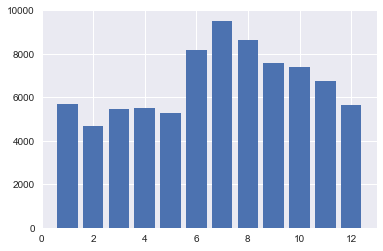

In [134]:
plt.bar(temp.index, temp)

In [136]:
temp = ufo['day'].value_counts()
temp.sort_index(inplace=True)


<BarContainer object of 31 artists>

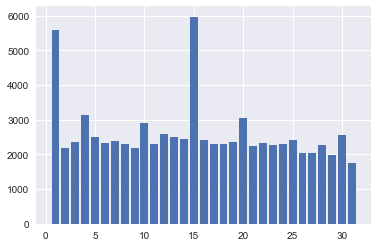

In [137]:
plt.bar(temp.index, temp)

In [138]:
ufo.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'comments',
       'date posted', 'latitude', 'longitude', 'duration_sec', 'duration_min',
       'longitude', 'year', 'month', 'day', 'day of the week', 'hour',
       'day of year'],
      dtype='object')

In [143]:
temp = ufo['hour'].value_counts()
temp.sort_index(inplace=True)


<BarContainer object of 24 artists>

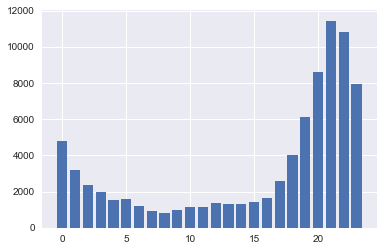

In [140]:
plt.bar(temp.index, temp)

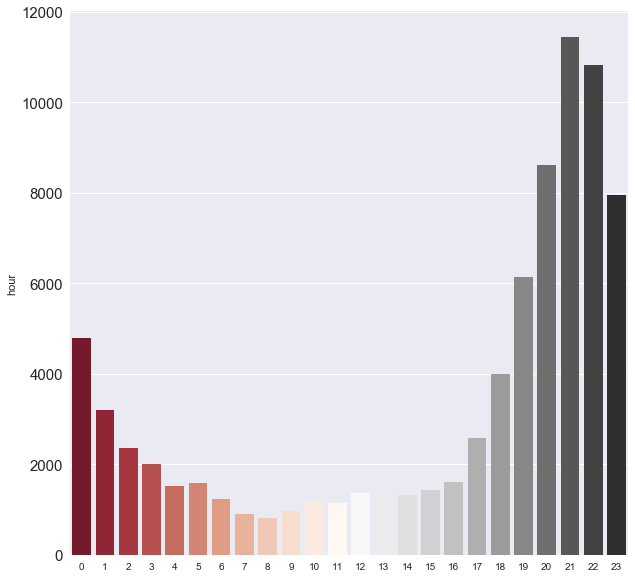

In [151]:
# TOFIX : background color to see the medium spectra
plt.figure(figsize=(10,10))
sns.barplot(temp.index, temp, palette="RdGy")
plt.yticks(fontsize=15)
plt.show()